In [53]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [55]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [56]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [57]:
tf.keras.backend.clear_session()

In [58]:
subject = 'Distrito Federal - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [59]:
data = pd.read_csv('2003_mo_model_input_DF.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - Consumo de Cimento (t),Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,50.047,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,48.110,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,49.006,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,48.445,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,51.436,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


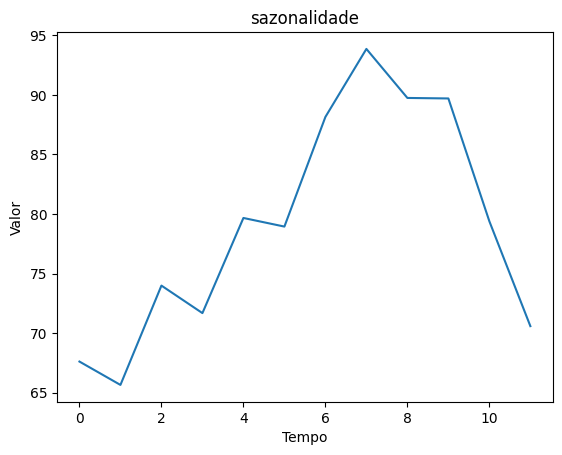

,sazonalidade
sazonalidade,
0,67.612260
1,65.651729
2,73.989587
3,71.679705
4,79.665749
5,78.942778
6,88.145534
7,93.855348
8,89.740323


In [60]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [61]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Distrito Federal - Consumo de Cimento (t)
0,2003-1,0.254227,4.896482e+06,8.293882,0.785137,12173.796800,0.835563,2.290151,887.301063,1472.275657,22.112973,15.990623,71.130346,2.506073,0.826971,0.871928,1.184017e+08,3.570616e+06,43.639430,1.092465e+08,156.625720,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,67.612260,50.047
1,2003-2,0.252655,4.934178e+06,8.287887,0.785313,12272.096031,0.835922,2.170793,887.625500,1467.038600,21.790128,15.663933,70.741484,2.494967,0.827063,0.871678,1.185511e+08,3.573184e+06,43.651300,1.093025e+08,157.678528,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,65.651729,48.110
2,2003-3,0.250972,4.971875e+06,8.281892,0.785489,12362.351216,0.836281,1.843974,887.995527,1443.186660,21.382001,14.859800,69.073150,2.482659,0.827155,0.871428,1.187006e+08,3.575752e+06,43.663170,1.093585e+08,159.190268,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,73.989587,49.006
3,2003-4,0.249179,5.009571e+06,8.275896,0.785664,12449.345859,0.836640,1.842883,888.753058,1484.414910,20.864040,13.463843,65.515153,2.541473,0.827247,0.871178,1.188500e+08,3.578320e+06,43.675041,1.094145e+08,160.688376,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,71.679705,48.445
4,2003-5,0.247070,5.047268e+06,8.269901,0.785840,12543.454480,0.836999,1.498497,889.051690,1487.564625,20.593129,12.206035,61.816227,2.562082,0.827340,0.870928,1.189994e+08,3.580889e+06,43.686911,1.094705e+08,162.847410,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,79.665749,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,NaN,NaN,NaN,2.285520,888.063858,1554.000510,22.107259,11.557766,54.920321,2.663202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.665749,NaN
269,2002-9,NaN,NaN,NaN,NaN,NaN,NaN,2.459765,887.482239,1504.599147,22.342946,12.632697,58.260143,2.597288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.942778,NaN
270,2002-10,NaN,NaN,NaN,NaN,NaN,NaN,2.404292,887.089138,1477.730987,22.495195,13.705746,61.921603,2.551755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.145534,NaN
271,2002-11,NaN,NaN,NaN,NaN,NaN,NaN,2.375765,887.036669,1469.367571,22.206488,14.859807,66.774435,2.510615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

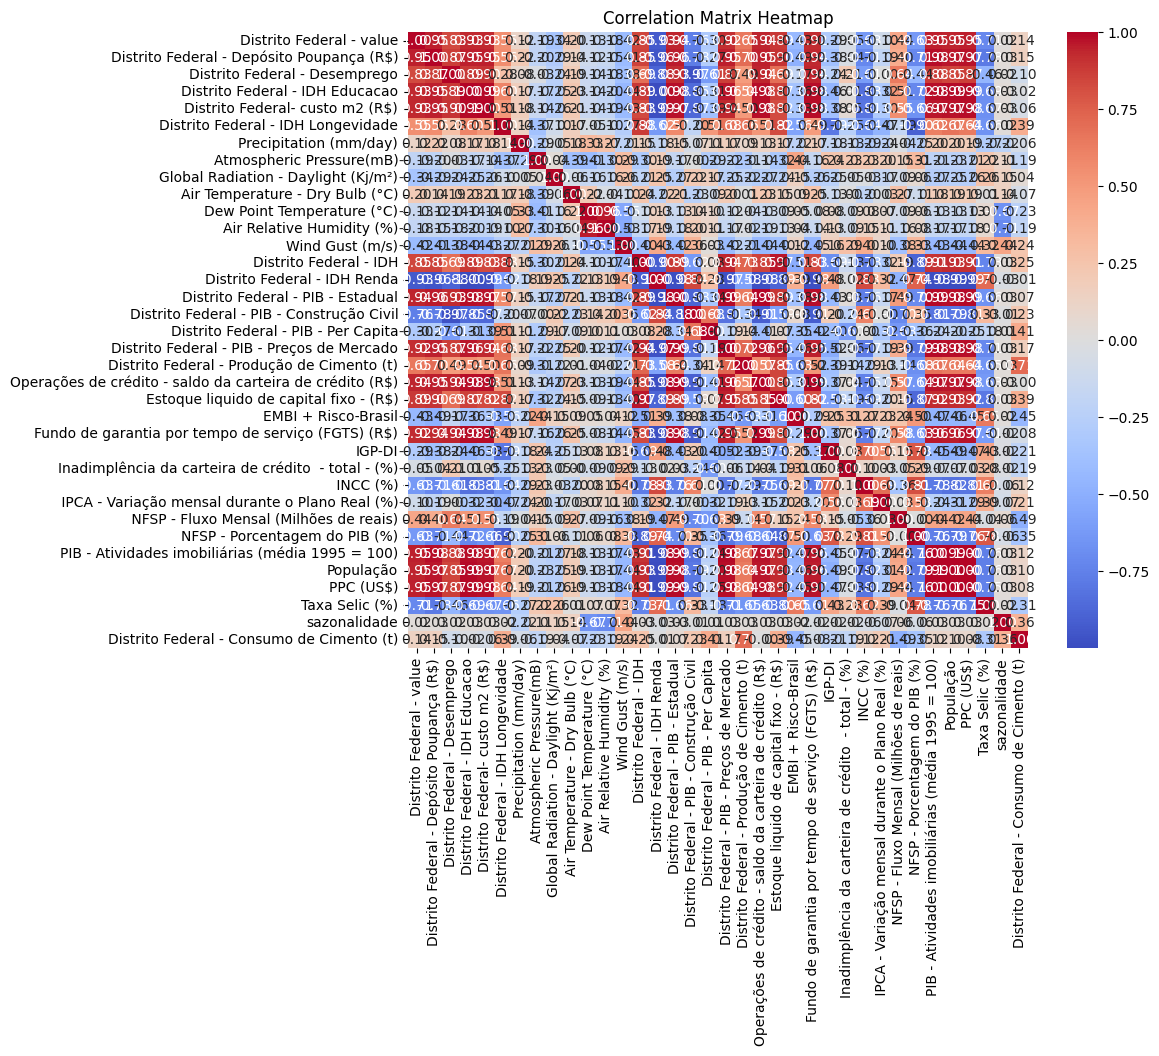

In [62]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [63]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [64]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.765895,-1.642474,-0.830412,-1.763693,-1.517786,-3.095887,0.277737,-0.119544,-0.280381,1.179433,1.185485,0.812336,0.534606,-2.593530,1.841463,-1.693822,0.396337,-2.171734,-2.205731,-1.931775,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.261248
1,-0.800114,-1.626663,-0.833674,-1.744288,-1.496840,-3.011873,-0.091026,0.070157,-0.284744,0.627546,1.008225,0.752759,0.473548,-2.541888,1.819205,-1.674984,0.431282,-2.081307,-2.163694,-1.908347,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.476881
2,-0.836745,-1.610853,-0.836936,-1.724883,-1.477609,-2.927859,-1.100747,0.286513,-0.304616,-0.070129,0.571905,0.497158,0.405876,-2.490246,1.796948,-1.656145,0.466227,-1.990880,-2.121657,-1.874707,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.559826
3,-0.875764,-1.595042,-0.840198,-1.705478,-1.459072,-2.843845,-1.104117,0.729447,-0.270268,-0.955559,-0.185537,-0.047954,0.729237,-2.438604,1.774690,-1.637307,0.501171,-1.900453,-2.079620,-1.841370,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.813883
4,-0.921678,-1.579232,-0.843461,-1.686072,-1.439019,-2.759832,-2.168114,0.904059,-0.267644,-1.418668,-0.868019,-0.614656,0.842545,-2.386962,1.752432,-1.618468,0.536116,-1.810026,-2.037583,-1.793327,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.064477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.298634,1.510848,1.198041,1.503469,1.793861,-0.562619,-0.057720,0.143581,-0.279406,0.343000,-0.780687,-0.889009,-1.198646,0.236110,-1.413347,1.116166,-1.071950,-1.286229,0.817896,-0.512069,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.625147
188,1.354774,1.534181,1.198255,1.508805,1.817755,-0.639389,0.942094,-0.181176,-0.289383,0.669601,-0.270236,-0.435587,-1.310058,0.183845,-1.417594,1.104850,-1.047047,-1.328476,0.799100,-0.500824,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.172548
189,1.401307,1.557514,1.198470,1.514141,1.842652,-0.716159,0.898651,-0.221957,-0.286952,0.821771,0.365487,0.113870,-1.337385,0.131580,-1.421840,1.093534,-1.022144,-1.370723,0.780305,-0.491677,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.167853
190,1.460103,1.580847,1.198684,1.519477,1.867712,-0.792930,0.302643,-0.280123,

In [65]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      46.442
1      43.234
2      54.587
3      59.228
4      63.997
        ...  
268       NaN
269       NaN
270       NaN
271       NaN
272       NaN
Name: Distrito Federal - Consumo de Cimento (t), Length: 273, dtype: float64

In [66]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.765895,-1.642474,-0.830412,-1.763693,-1.517786,-3.095887,0.277737,-0.119544,-0.280381,1.179433,1.185485,0.812336,0.534606,-2.593530,1.841463,-1.693822,0.396337,-2.171734,-2.205731,-1.931775,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.261248
1,-0.800114,-1.626663,-0.833674,-1.744288,-1.496840,-3.011873,-0.091026,0.070157,-0.284744,0.627546,1.008225,0.752759,0.473548,-2.541888,1.819205,-1.674984,0.431282,-2.081307,-2.163694,-1.908347,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.476881
2,-0.836745,-1.610853,-0.836936,-1.724883,-1.477609,-2.927859,-1.100747,0.286513,-0.304616,-0.070129,0.571905,0.497158,0.405876,-2.490246,1.796948,-1.656145,0.466227,-1.990880,-2.121657,-1.874707,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-0.559826
3,-0.875764,-1.595042,-0.840198,-1.705478,-1.459072,-2.843845,-1.104117,0.729447,-0.270268,-0.955559,-0.185537,-0.047954,0.729237,-2.438604,1.774690,-1.637307,0.501171,-1.900453,-2.079620,-1.841370,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.813883
4,-0.921678,-1.579232,-0.843461,-1.686072,-1.439019,-2.759832,-2.168114,0.904059,-0.267644,-1.418668,-0.868019,-0.614656,0.842545,-2.386962,1.752432,-1.618468,0.536116,-1.810026,-2.037583,-1.793327,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,0.064477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.937260,0.537374,1.309227,1.382711,1.089645,1.313827,-0.839849,0.040510,-0.187966,2.074338,0.723376,0.038677,-1.173917,1.616226,-1.304769,1.235244,-1.506889,-0.747477,1.174551,0.131039,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.476881
158,0.925760,0.568577,1.302282,1.375753,1.110965,1.261775,-1.200099,0.377452,-0.223321,1.301918,0.279582,-0.224239,-0.988546,1.563561,-1.311738,1.236423,-1.511843,-0.763990,1.168128,0.077457,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,-0.559826
159,0.912813,0.599779,1.295337,1.368794,1.132605,1.209724,-1.560955,0.645732,-0.210251,0.688334,-0.489394,-0.857990,-0.768463,1.510895,-1.318707,1.237602,-1.516798,-0.780503,1.161706,0.032090,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-0.813883
160,0.906620,0.630982,1.288392,1.361835,1.154633,1.157672,-1.699882,0.898495,-0.222246,0

In [67]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      46.442
1      43.234
2      54.587
3      59.228
4      63.997
        ...  
157    35.599
158    49.981
159    39.881
160    48.598
161    49.942
Name: Distrito Federal - Consumo de Cimento (t), Length: 162, dtype: float64

In [68]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [69]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [70]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Distrito Federal - value,Distrito Federal - Depósito Poupança (R$),Distrito Federal - Desemprego,Distrito Federal - IDH Educacao,Distrito Federal- custo m2 (R$),Distrito Federal - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Distrito Federal - IDH,Distrito Federal - IDH Renda,Distrito Federal - PIB - Estadual,Distrito Federal - PIB - Construção Civil,Distrito Federal - PIB - Per Capita,Distrito Federal - PIB - Preços de Mercado,Distrito Federal - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.746963,1.209537,0.952687,0.544256,0.473049,0.283123,-0.613104,0.329520,-0.238450,-0.632531,-1.103927,-1.014495,0.824826,0.686090,-0.623130,0.806860,-0.638912,-0.325093,0.894339,1.712291,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.997142
127,0.759387,1.207127,0.973455,0.553116,0.491864,0.251936,-0.425963,-0.036556,-0.240084,-0.084677,-0.828398,-0.867761,0.901915,0.670518,-0.624171,0.828599,-0.679356,-0.322764,0.917121,1.675940,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.625147
128,0.775249,1.204718,0.994223,0.561976,0.511129,0.220749,-0.389430,-0.459764,-0.286784,0.137120,-0.086861,-0.127310,0.768945,0.654947,-0.625213,0.850339,-0.719800,-0.320434,0.939903,1.626852,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,1.172548
129,0.795874,1.202308,1.014990,0.570835,0.529664,0.189562,0.470197,-0.665622,-0.274696,0.214746,0.352792,0.309173,0.335289,0.639375,-0.626254,0.872078,-0.760244,-0.318105,0.962685,1.569267,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.167853
130,0.815598,1.199899,1.035758,0.579695,0.548618,0.158374,0.981576,-0.862440,-0.270397,0.312303,0.663964,0.600351,0.232565,0.623804,-0.627295,0.893818,-0.800689,-0.315775,0.985467,1.514446,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.033836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.298634,1.510848,1.198041,1.503469,1.793861,-0.562619,-0.057720,0.143581,-0.279406,0.343000,-0.780687,-0.889009,-1.198646,0.236110,-1.413347,1.116166,-1.071950,-1.286229,0.817896,-0.512069,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.625147
188,1.354774,1.534181,1.198255,1.508805,1.817755,-0.639389,0.942094,-0.181176,-0.289383,0.669601,-0.270236,-0.435587,-1.310058,0.183845,-1.417594,1.104850,-1.047047,-1.328476,0.799100,-0.500824,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,1.172548
189,1.401307,1.557514,1.198470,1.514141,1.842652,-0.716159,0.898651,-0.221957,-0.286952,0.821771,0.365487,0.113870,-1.337385,0.131580,-1.421840,1.093534,-1.022144,-1.370723,0.780305,-0.491677,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.167853
190,1.460103,1.580847,1.198684,1.519477,1.867712,-0.792930,0.302643,-0.280123,-0.278081,0.770652,0.720094,0.51508

In [71]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [72]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [73]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [74]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(100)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_val_loss = min(history.history['val_loss'][500:])
        current_loss = history.history['loss'][history.history['val_loss'].index(current_val_loss)]
        decision_value = (current_val_loss*current_val_loss)*current_loss 
        print(f"val_loss: {current_val_loss}; loss={current_loss} => decision_value={decision_value}")

        if decision_value < best_loss:
            best_loss = decision_value
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [75]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[4005884762, 4163137066, 1447006677, 1828687065, 3868211269, 778312560, 3907767286, 3251737726, 574250941, 717177427, 4257590065, 1536277169, 2848954958, 3892219276, 736726644, 2886090417, 4261491852, 655425874, 1716902563, 627500798, 1588236244, 3124303696, 3513368981, 3481925534, 3449610126, 4110071745, 4223907532, 722525943, 354429564, 3288660768, 3330668100, 257417082, 3067522757, 2191781315, 3697432811, 2422683902, 1650846846, 357612247, 3281811078, 1566719280, 2991077406, 659189814, 2874702184, 3545199735, 310381258, 502808365, 2442422035, 1290946441, 2950652227, 1638702568, 3265850087, 1444571023, 3263961684, 523466543, 1858980968, 4070985639, 891263527, 2520514394, 3745579309, 2581012105, 3907346332, 3258304508, 1122295234, 2306081792, 4053094238, 2944744202, 3631979572, 3935318897, 2803127518, 64703198, 3359096953, 1507502928, 1028795974, 1890713896, 2099442057, 3996563064, 3310942872, 630627168, 3055752920, 2371663850, 1455984361, 1358375874, 3272390181, 1608419825, 217937305

val_loss: 24.858116149902344; loss=13.104597091674805 => decision_value=8097.670456826293


Step: 49 ___________________________________________
val_loss: 24.07378387451172; loss=16.13680648803711 => decision_value=9352.038919891125


Step: 50 ___________________________________________
val_loss: 32.33345031738281; loss=13.43032455444336 => decision_value=14040.759792695058


Step: 51 ___________________________________________
val_loss: 24.999794006347656; loss=20.666261672973633 => decision_value=12916.200690549345


Step: 52 ___________________________________________
val_loss: 27.880144119262695; loss=12.941447257995605 => decision_value=10059.41848044017


Step: 53 ___________________________________________
val_loss: 25.49463653564453; loss=16.39764976501465 => decision_value=10658.08687269643


Step: 54 ___________________________________________
val_loss: 30.216936111450195; loss=19.757186889648438 => decision_value=18039.56083693981


Step: 55 _________________________________

In [76]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3105829098

Epoch 1/10000
4/4 [==============================] - 2s 134ms/step - loss: 5732.7363 - val_loss: 934.0220
Epoch 2/10000
4/4 [==============================] - 0s 15ms/step - loss: 577.1129 - val_loss: 783.0256
Epoch 3/10000
4/4 [==============================] - 0s 14ms/step - loss: 585.9094 - val_loss: 597.6269
Epoch 4/10000
4/4 [==============================] - 0s 12ms/step - loss: 501.6318 - val_loss: 824.6902
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 505.9863 - val_loss: 489.1576
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 438.8398 - val_loss: 670.3661
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 328.8901 - val_loss: 1279.4214
Epoch 8/10000
4/4 [==============================] - 0s 14ms/step - loss: 896.3008 - val_loss: 510.3131
Epoch 9/10000
4/4 [==============================] - 0s 14ms/step - loss: 345.4078 - val_loss: 416.7733
Epoch 10/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 13ms/step - loss: 39.6307 - val_loss: 46.4936
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 37.2481 - val_loss: 48.5041
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.5504 - val_loss: 50.2633
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.8454 - val_loss: 49.4791
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.0603 - val_loss: 84.4085
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 77.3855 - val_loss: 109.2112
Epoch 86/10000
4/4 [==============================] - 0s 13ms/step - loss: 52.0385 - val_loss: 36.8023
Epoch 87/10000
4/4 [==============================] - 0s 13ms/step - loss: 30.5398 - val_loss: 38.0495
Epoch 88/10000
4/4 [==============================] - 0s 14ms/step - loss: 31.4773 - val_loss: 82.7067
Epoch 89/10000
4/4 [==============================] - 0s 13ms/step - loss: 38.3096 - va

4/4 [==============================] - 0s 13ms/step - loss: 42.8501 - val_loss: 44.6937
Epoch 160/10000
4/4 [==============================] - 0s 13ms/step - loss: 26.8442 - val_loss: 62.0704
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.6232 - val_loss: 38.2961
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.5307 - val_loss: 29.0531
Epoch 163/10000
4/4 [==============================] - 0s 13ms/step - loss: 25.7751 - val_loss: 28.5186
Epoch 164/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.5922 - val_loss: 34.1189
Epoch 165/10000
4/4 [==============================] - 0s 14ms/step - loss: 30.3073 - val_loss: 49.5291
Epoch 166/10000
4/4 [==============================] - 0s 13ms/step - loss: 31.0194 - val_loss: 46.4787
Epoch 167/10000
4/4 [==============================] - 0s 13ms/step - loss: 66.4122 - val_loss: 36.3197
Epoch 168/10000
4/4 [==============================] - 0s 14ms/step - loss: 25.8

Epoch 238/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.9152 - val_loss: 35.7343
Epoch 239/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.1329 - val_loss: 35.4710
Epoch 240/10000
4/4 [==============================] - 0s 13ms/step - loss: 22.5045 - val_loss: 57.8239
Epoch 241/10000
4/4 [==============================] - 0s 12ms/step - loss: 36.3601 - val_loss: 53.6029
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.7502 - val_loss: 66.7503
Epoch 243/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.3135 - val_loss: 46.1111
Epoch 244/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.3605 - val_loss: 36.5209
Epoch 245/10000
4/4 [==============================] - 0s 14ms/step - loss: 31.5790 - val_loss: 59.8647
Epoch 246/10000
4/4 [==============================] - 0s 13ms/step - loss: 22.6515 - val_loss: 32.8091
Epoch 247/10000
4/4 [==============================] - 0s 12ms/s

Epoch 317/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.3262 - val_loss: 34.7695
Epoch 318/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.4840 - val_loss: 42.0682
Epoch 319/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.6209 - val_loss: 46.4921
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.5293 - val_loss: 40.6453
Epoch 321/10000
4/4 [==============================] - 0s 13ms/step - loss: 23.2686 - val_loss: 40.1367
Epoch 322/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.6609 - val_loss: 48.0342
Epoch 323/10000
4/4 [==============================] - 0s 13ms/step - loss: 28.2544 - val_loss: 28.6238
Epoch 324/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.7696 - val_loss: 40.9912
Epoch 325/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.2548 - val_loss: 35.6733
Epoch 326/10000
4/4 [==============================] - 0s 13ms/s

Epoch 396/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.2606 - val_loss: 39.4854
Epoch 397/10000
4/4 [==============================] - 0s 13ms/step - loss: 26.3653 - val_loss: 37.7313
Epoch 398/10000
4/4 [==============================] - 0s 13ms/step - loss: 21.6892 - val_loss: 36.2049
Epoch 399/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.4880 - val_loss: 42.6226
Epoch 400/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.1372 - val_loss: 34.0807
Epoch 401/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.2617 - val_loss: 42.4261
Epoch 402/10000
4/4 [==============================] - 0s 14ms/step - loss: 25.2018 - val_loss: 33.6120
Epoch 403/10000
4/4 [==============================] - 0s 13ms/step - loss: 19.2154 - val_loss: 29.6740
Epoch 404/10000
4/4 [==============================] - 0s 13ms/step - loss: 20.6989 - val_loss: 31.2627
Epoch 405/10000
4/4 [==============================] - 0s 13ms/s

Epoch 475/10000
4/4 [==============================] - 0s 13ms/step - loss: 18.9940 - val_loss: 44.6550
Epoch 476/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.2302 - val_loss: 34.8174
Epoch 477/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.5376 - val_loss: 28.3044
Epoch 478/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.1835 - val_loss: 33.4377
Epoch 479/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.5132 - val_loss: 32.3848
Epoch 480/10000
4/4 [==============================] - 0s 13ms/step - loss: 24.2024 - val_loss: 43.1414
Epoch 481/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.9472 - val_loss: 30.9590
Epoch 482/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.6422 - val_loss: 34.6578
Epoch 483/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.9914 - val_loss: 32.5896
Epoch 484/10000
4/4 [==============================] - 0s 14ms/s

Epoch 554/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.6555 - val_loss: 32.9399
Epoch 555/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.8613 - val_loss: 36.2426
Epoch 556/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.4726 - val_loss: 32.2663
Epoch 557/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.4308 - val_loss: 36.6171
Epoch 558/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.4283 - val_loss: 39.8982
Epoch 559/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.1443 - val_loss: 35.4392
Epoch 560/10000
4/4 [==============================] - 0s 13ms/step - loss: 20.6536 - val_loss: 70.8575
Epoch 561/10000
4/4 [==============================] - 0s 14ms/step - loss: 26.9031 - val_loss: 47.5304
Epoch 562/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.8117 - val_loss: 32.5737
Epoch 563/10000
4/4 [==============================] - 0s 13ms/s

Epoch 633/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.0384 - val_loss: 34.3743
Epoch 634/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.1238 - val_loss: 34.1210
Epoch 635/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.1948 - val_loss: 28.6557
Epoch 636/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.5468 - val_loss: 34.8440
Epoch 637/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.8622 - val_loss: 31.8538
Epoch 638/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.0202 - val_loss: 36.7270
Epoch 639/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.0232 - val_loss: 35.5972
Epoch 640/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.4729 - val_loss: 34.7619
Epoch 641/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.4616 - val_loss: 32.9621
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step -

4/4 [==============================] - 0s 13ms/step - loss: 13.4850 - val_loss: 32.7267
Epoch 713/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.1845 - val_loss: 28.0678
Epoch 714/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.1485 - val_loss: 36.7927
Epoch 715/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.6202 - val_loss: 32.6380
Epoch 716/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.7390 - val_loss: 27.0096
Epoch 717/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.7446 - val_loss: 27.4370
Epoch 718/10000
4/4 [==============================] - 0s 14ms/step - loss: 12.8672 - val_loss: 27.8121
Epoch 719/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.0464 - val_loss: 33.1532
Epoch 720/10000
4/4 [==============================] - 0s 14ms/step - loss: 13.7106 - val_loss: 30.2717
Epoch 721/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.3

Epoch 791/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.5072 - val_loss: 30.1799
Epoch 792/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.9112 - val_loss: 27.5821
Epoch 793/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.7045 - val_loss: 38.5652
Epoch 794/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.1323 - val_loss: 31.0094
Epoch 795/10000
4/4 [==============================] - 0s 13ms/step - loss: 17.3305 - val_loss: 33.2926
Epoch 796/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.4139 - val_loss: 33.0318
Epoch 797/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.3542 - val_loss: 30.3379
Epoch 798/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.4485 - val_loss: 32.4519
Epoch 799/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.1289 - val_loss: 32.2192
Epoch 800/10000
4/4 [==============================] - 0s 13ms/s

Epoch 870/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.3128 - val_loss: 35.5712
Epoch 871/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.4526 - val_loss: 31.1249
Epoch 872/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.0400 - val_loss: 39.7528
Epoch 873/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.0266 - val_loss: 36.3218
Epoch 874/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.8162 - val_loss: 31.7925
Epoch 875/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.4084 - val_loss: 37.4000
Epoch 876/10000
4/4 [==============================] - 0s 14ms/step - loss: 14.8708 - val_loss: 36.5958
Epoch 877/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.6835 - val_loss: 33.7972
Epoch 878/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.3985 - val_loss: 37.2279
Epoch 879/10000
4/4 [==============================] - 0s 14ms/s

Epoch 949/10000
4/4 [==============================] - 0s 13ms/step - loss: 13.3254 - val_loss: 34.2349
Epoch 950/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.3524 - val_loss: 38.6574
Epoch 951/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.2952 - val_loss: 35.0831
Epoch 952/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.1644 - val_loss: 32.6842
Epoch 953/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.1982 - val_loss: 35.0864
Epoch 954/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.4571 - val_loss: 32.4113
Epoch 955/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.2287 - val_loss: 34.3117
Epoch 956/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.7942 - val_loss: 31.8438
Epoch 957/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.9639 - val_loss: 31.7341
Epoch 958/10000
4/4 [==============================] - 0s 13ms/s

4/4 [==============================] - 0s 12ms/step - loss: 15.0523 - val_loss: 31.8913
Epoch 1028/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.6539 - val_loss: 30.9155
Epoch 1029/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.4354 - val_loss: 34.7137
Epoch 1030/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.9107 - val_loss: 29.0599
Epoch 1031/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.1652 - val_loss: 33.1041
Epoch 1032/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.9608 - val_loss: 31.9015
Epoch 1033/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.3072 - val_loss: 35.4325
Epoch 1034/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.2339 - val_loss: 30.9231
Epoch 1035/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.7322 - val_loss: 34.9170
Epoch 1036/10000
4/4 [==============================] - 0s 14ms/step - los

4/4 [==============================] - 0s 13ms/step - loss: 8.8864 - val_loss: 31.3648
Epoch 1106/10000
4/4 [==============================] - 0s 12ms/step - loss: 11.0121 - val_loss: 37.2318
Epoch 1107/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.4034 - val_loss: 30.0243
Epoch 1108/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.9627 - val_loss: 34.5496
Epoch 1109/10000
4/4 [==============================] - 0s 13ms/step - loss: 12.7389 - val_loss: 35.9659
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.3941 - val_loss: 26.8076
Epoch 1111/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.9641 - val_loss: 29.1518
Epoch 1112/10000
4/4 [==============================] - 0s 14ms/step - loss: 10.1891 - val_loss: 36.4505
Epoch 1113/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.6693 - val_loss: 31.8446
Epoch 1114/10000
4/4 [==============================] - 0s 14ms/step - loss:

4/4 [==============================] - 0s 13ms/step - loss: 9.4400 - val_loss: 31.9681
Epoch 1184/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.5635 - val_loss: 32.8031
Epoch 1185/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.8650 - val_loss: 31.7319
Epoch 1186/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.9283 - val_loss: 31.6007
Epoch 1187/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.7775 - val_loss: 33.7287
Epoch 1188/10000
4/4 [==============================] - 0s 14ms/step - loss: 8.9080 - val_loss: 52.3160
Epoch 1189/10000
4/4 [==============================] - 0s 13ms/step - loss: 14.1318 - val_loss: 31.4151
Epoch 1190/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.2833 - val_loss: 29.3078
Epoch 1191/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.2654 - val_loss: 28.8726
Epoch 1192/10000
4/4 [==============================] - 0s 13ms/step - loss: 8

Epoch 1262/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.2889 - val_loss: 27.9418
Epoch 1263/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.7608 - val_loss: 28.6052
Epoch 1264/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.0445 - val_loss: 27.1928
Epoch 1265/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.2494 - val_loss: 36.1794
Epoch 1266/10000
4/4 [==============================] - 0s 14ms/step - loss: 10.5615 - val_loss: 30.7084
Epoch 1267/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.9293 - val_loss: 29.7088
Epoch 1268/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.2528 - val_loss: 25.3098
Epoch 1269/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.8364 - val_loss: 24.0793
Epoch 1270/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.0398 - val_loss: 29.1045
Epoch 1271/10000
4/4 [==============================] - 0s 14m

4/4 [==============================] - 0s 12ms/step - loss: 8.7505 - val_loss: 25.6132
Epoch 1341/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.4088 - val_loss: 26.3125
Epoch 1342/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.2118 - val_loss: 27.5188
Epoch 1343/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.6584 - val_loss: 24.3959
Epoch 1344/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.3974 - val_loss: 29.1287
Epoch 1345/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.9634 - val_loss: 28.2399
Epoch 1346/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.8773 - val_loss: 24.6687
Epoch 1347/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.0801 - val_loss: 25.2836
Epoch 1348/10000
4/4 [==============================] - 0s 13ms/step - loss: 9.1931 - val_loss: 25.2398
Epoch 1349/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.5

Epoch 1419/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8109 - val_loss: 27.2733
Epoch 1420/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8448 - val_loss: 31.5358
Epoch 1421/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.0165 - val_loss: 29.8617
Epoch 1422/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.6084 - val_loss: 27.5923
Epoch 1423/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6333 - val_loss: 30.4525
Epoch 1424/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.2047 - val_loss: 30.1796
Epoch 1425/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.9592 - val_loss: 27.5520
Epoch 1426/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.3443 - val_loss: 30.7032
Epoch 1427/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.9525 - val_loss: 25.3978
Epoch 1428/10000
4/4 [==============================] - 0s 13ms/

Epoch 1498/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.1331 - val_loss: 24.2104
Epoch 1499/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.3878 - val_loss: 24.5993
Epoch 1500/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.4281 - val_loss: 26.6012
Epoch 1501/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.7742 - val_loss: 26.0529
Epoch 1502/10000
4/4 [==============================] - 0s 13ms/step - loss: 8.9105 - val_loss: 31.0587
Epoch 1503/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.7633 - val_loss: 28.7386
Epoch 1504/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.2755 - val_loss: 26.3409
Epoch 1505/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.8997 - val_loss: 25.6439
Epoch 1506/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.3281 - val_loss: 27.9373
Epoch 1507/10000
4/4 [==============================] - 0s 13ms/

Epoch 1577/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.1992 - val_loss: 30.1825
Epoch 1578/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.7123 - val_loss: 23.9105
Epoch 1579/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.0961 - val_loss: 26.2576
Epoch 1580/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.1061 - val_loss: 26.0785
Epoch 1581/10000
4/4 [==============================] - 0s 14ms/step - loss: 6.9458 - val_loss: 23.2200
Epoch 1582/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.1955 - val_loss: 26.8361
Epoch 1583/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.3663 - val_loss: 26.5391
Epoch 1584/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.8947 - val_loss: 25.1138
Epoch 1585/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.7456 - val_loss: 27.6180
Epoch 1586/10000
4/4 [==============================] - 0s 14ms/

Epoch 1656/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.4582 - val_loss: 26.3042
Epoch 1657/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.5654 - val_loss: 26.0982
Epoch 1658/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.9821 - val_loss: 27.5325
Epoch 1659/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.7116 - val_loss: 24.7482
Epoch 1660/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.8216 - val_loss: 29.4026
Epoch 1661/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.5692 - val_loss: 23.5819
Epoch 1662/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.3335 - val_loss: 30.6034
Epoch 1663/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.6903 - val_loss: 24.7413
Epoch 1664/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.0081 - val_loss: 27.2179
Epoch 1665/10000
4/4 [==============================] - 0s 13ms/

Epoch 1735/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.7104 - val_loss: 23.7816
Epoch 1736/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.1380 - val_loss: 23.8094
Epoch 1737/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.8274 - val_loss: 23.7557
Epoch 1738/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.4934 - val_loss: 25.1628
Epoch 1739/10000
4/4 [==============================] - 0s 14ms/step - loss: 4.8491 - val_loss: 28.8558
Epoch 1740/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.6290 - val_loss: 25.1368
Epoch 1741/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.0966 - val_loss: 30.1551
Epoch 1742/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.8268 - val_loss: 27.8718
Epoch 1743/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.9622 - val_loss: 26.9193
Epoch 1744/10000
4/4 [==============================] - 0s 13ms/

Epoch 1814/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5597 - val_loss: 24.9223
Epoch 1815/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5954 - val_loss: 24.1781
Epoch 1816/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.4482 - val_loss: 26.9429
Epoch 1817/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.7412 - val_loss: 26.1197
Epoch 1818/10000
4/4 [==============================] - 0s 14ms/step - loss: 8.2223 - val_loss: 24.2719
Epoch 1819/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.8064 - val_loss: 24.5757
Epoch 1820/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.1702 - val_loss: 29.4901
Epoch 1821/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.5531 - val_loss: 24.5496
Epoch 1822/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.0722 - val_loss: 24.1576
Epoch 1823/10000
4/4 [==============================] - 0s 12ms/

Epoch 1893/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.2054 - val_loss: 29.3894
Epoch 1894/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.2845 - val_loss: 25.3340
Epoch 1895/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.4877 - val_loss: 25.6716
Epoch 1896/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.7580 - val_loss: 29.1006
Epoch 1897/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.9334 - val_loss: 27.2811
Epoch 1898/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.3824 - val_loss: 24.9013
Epoch 1899/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.8057 - val_loss: 24.0298
Epoch 1900/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.7417 - val_loss: 27.7746
Epoch 1901/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2432 - val_loss: 28.5254
Epoch 1902/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 9ms/step - loss: 4.6564 - val_loss: 23.6581
Epoch 1973/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4475 - val_loss: 27.0970
Epoch 1974/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0136 - val_loss: 25.8536
Epoch 1975/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6436 - val_loss: 26.3079
Epoch 1976/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2977 - val_loss: 25.5034
Epoch 1977/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2101 - val_loss: 25.3632
Epoch 1978/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8096 - val_loss: 24.1576
Epoch 1979/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1711 - val_loss: 31.3195
Epoch 1980/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6801 - val_loss: 27.4090
Epoch 1981/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7183 - v

4/4 [==============================] - 0s 13ms/step - loss: 5.3220 - val_loss: 29.6290
Epoch 2052/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.4937 - val_loss: 28.1080
Epoch 2053/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.5664 - val_loss: 29.0824
Epoch 2054/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.1452 - val_loss: 29.3090
Epoch 2055/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.8018 - val_loss: 26.3814
Epoch 2056/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.2395 - val_loss: 28.9340
Epoch 2057/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.7417 - val_loss: 27.6628
Epoch 2058/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.0499 - val_loss: 29.0627
Epoch 2059/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.6588 - val_loss: 26.3451
Epoch 2060/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.51

Epoch 2130/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.3561 - val_loss: 26.5046
Epoch 2131/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.9965 - val_loss: 28.6165
Epoch 2132/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.6782 - val_loss: 26.3358
Epoch 2133/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.4444 - val_loss: 30.4788
Epoch 2134/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.5759 - val_loss: 26.8244
Epoch 2135/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.5197 - val_loss: 25.9037
Epoch 2136/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0417 - val_loss: 30.1822
Epoch 2137/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.5630 - val_loss: 24.4330
Epoch 2138/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.3647 - val_loss: 25.9852
Epoch 2139/10000
4/4 [==============================] - 0s 13ms/

Epoch 2209/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.4277 - val_loss: 24.6837
Epoch 2210/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.7992 - val_loss: 25.5324
Epoch 2211/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5367 - val_loss: 27.3656
Epoch 2212/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.8919 - val_loss: 28.3003
Epoch 2213/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.8619 - val_loss: 25.8975
Epoch 2214/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.4070 - val_loss: 26.1532
Epoch 2215/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.7419 - val_loss: 25.3178
Epoch 2216/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.0673 - val_loss: 24.9119
Epoch 2217/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.1417 - val_loss: 24.6364
Epoch 2218/10000
4/4 [==============================] - 0s 12ms/

Epoch 2288/10000
4/4 [==============================] - 0s 13ms/step - loss: 5.1021 - val_loss: 27.0163
Epoch 2289/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.8249 - val_loss: 26.2068
Epoch 2290/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.3682 - val_loss: 27.4642
Epoch 2291/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.3513 - val_loss: 25.6929
Epoch 2292/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.5810 - val_loss: 26.8794
Epoch 2293/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.6383 - val_loss: 28.7055
Epoch 2294/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.4838 - val_loss: 26.9861
Epoch 2295/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.9929 - val_loss: 26.4479
Epoch 2296/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.4826 - val_loss: 25.8158
Epoch 2297/10000
4/4 [==============================] - 0s 13ms/

Epoch 2367/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.4605 - val_loss: 29.1694
Epoch 2368/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9295 - val_loss: 29.8394
Epoch 2369/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3340 - val_loss: 27.3933
Epoch 2370/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0688 - val_loss: 24.2012
Epoch 2371/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7959 - val_loss: 26.5745
Epoch 2372/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4199 - val_loss: 28.0819
Epoch 2373/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7726 - val_loss: 28.5005
Epoch 2374/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4571 - val_loss: 25.8694
Epoch 2375/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4582 - val_loss: 24.6727
Epoch 2376/10000
4/4 [==============================] - 0s 12ms/

Epoch 2446/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.2362 - val_loss: 28.9545
Epoch 2447/10000
4/4 [==============================] - 0s 13ms/step - loss: 3.9438 - val_loss: 24.5351
Epoch 2448/10000
4/4 [==============================] - 0s 14ms/step - loss: 3.5727 - val_loss: 26.1279
Epoch 2449/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.9830 - val_loss: 25.0820
Epoch 2450/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.7940 - val_loss: 25.0124
Epoch 2451/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.7768 - val_loss: 24.9609
Epoch 2452/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.6986 - val_loss: 26.4459
Epoch 2453/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.2371 - val_loss: 25.6155
Epoch 2454/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.1798 - val_loss: 24.5452
Epoch 2455/10000
4/4 [==============================] - 0s 12ms/

Epoch 2525/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.2430 - val_loss: 28.4511
Epoch 2526/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3189 - val_loss: 26.6750
Epoch 2527/10000
4/4 [==============================] - 0s 16ms/step - loss: 2.5600 - val_loss: 28.1510
Epoch 2528/10000
4/4 [==============================] - 0s 15ms/step - loss: 3.2545 - val_loss: 24.3800
Epoch 2529/10000
4/4 [==============================] - 0s 13ms/step - loss: 2.9087 - val_loss: 27.5462
Epoch 2530/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.0297 - val_loss: 26.1212
Epoch 2531/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2259 - val_loss: 25.6972
Epoch 2532/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.5007 - val_loss: 25.7978
Epoch 2533/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0361 - val_loss: 25.8839
Epoch 2534/10000
4/4 [==============================] - 0s 12ms/

In [77]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [78]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,50.753025,53.287395,52.241547,51.137512,54.092079,45.92738,43.279797,38.696941,46.339031,40.03167,47.636246,47.737061,51.941929,54.102131,55.560646,55.776848,49.709877,53.428898,44.639904,40.949478,46.778572,43.01149,49.927086,51.564522,55.936356,53.327736,55.765373,49.340057,47.866714,46.374287
Target,53.235,59.29,54.875,57.52,49.573,40.698,47.195,43.527,45.488,44.96,36.721,54.463,51.462,58.854,53.94,51.514,42.635,40.371,48.99,44.726,44.491,43.901,55.019,50.942,63.992,64.127,60.822,65.182,51.282,43.554
Error,2.481976,6.002605,2.633453,6.382488,4.519077,5.229378,3.915203,4.830059,0.851032,4.928329,10.915245,6.725941,0.479927,4.751869,1.620647,4.262848,7.074879,13.057899,4.350098,3.776524,2.287571,0.889511,5.091915,0.62252,8.055645,10.799263,5.056625,15.841942,3.415287,2.820286


In [79]:
display(mae)
display(mape)

5.122335

0.102107085

In [80]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [81]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[571.15967]] - Target[587.5449999999998]| =  Error: [[16.385315]]; MAPE:[[0.02788776]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[597.3913]] - Target[586.845]| =  Error: [[10.546326]]; MAPE:[[0.01797123]]
1/1 [==============================] - 0s 16ms/step
Ano-5: |Prediction[[308.61053]] - Target[348.95899999999995]| =  Error: [[40.34848]]; MAPE:[[0.11562527]]


[array([[16.385315]], dtype=float32),
 array([[10.546326]], dtype=float32),
 array([[40.34848]], dtype=float32)]

22.426706

0.053828087